In [ ]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import joblib
from collections import defaultdict

import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
data = pd.read_csv("prepared_data_vf.csv")
test = pd.read_csv("prepared_data_vf2.csv")
plott= pd.read_csv("prepared_data_vf3.csv")

In [6]:
corr=pd.read_csv("data_final.csv")
corr= corr[['LON','LAT','T2M','PRECTOTCORR','RH2M','WS2M']]


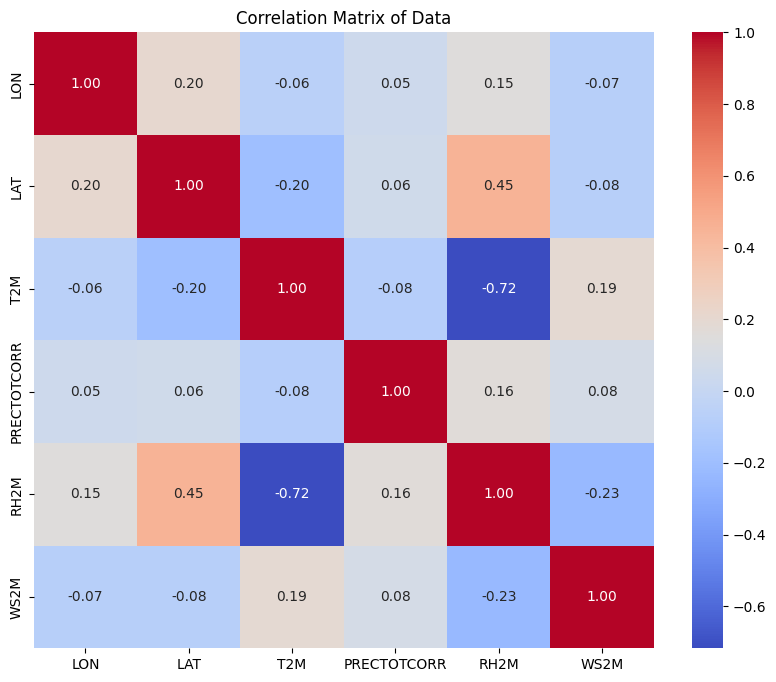

In [7]:
plt.figure(figsize=(10, 8))
corr2 = corr.corr()
sns.heatmap(corr2, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Data")
plt.show()

#### Train

In [3]:
df = data.copy()
X_pos = df[['LON','LAT','timestamp']]
X_feat= df[['LON','LAT','timestamp','T2M_1','T2M_2','T2M_3','PRECTOTCORR_1','PRECTOTCORR_2','PRECTOTCORR_3','RH2M_1','WS2M_1']]
y=df[['T2M_target_1','PRECTOTCORR_target_1']]

#### Test

In [4]:
df_test = test.copy()
X_pos = df_test[['LON','LAT','timestamp']]
X_feat_test= df_test[['LON','LAT','timestamp','T2M_1','T2M_2','T2M_3','PRECTOTCORR_1','PRECTOTCORR_2','PRECTOTCORR_3','RH2M_1','WS2M_1']]
y_test=df_test[['T2M_target_1','PRECTOTCORR_target_1']]

In [76]:
loc_df = plott[(plott['LAT'] == 36.7024) & (plott['LON'] == 3.098060)].copy()
X_feat_plott= loc_df[['LON','LAT','timestamp','T2M_1','T2M_2','T2M_3','PRECTOTCORR_1','PRECTOTCORR_2','PRECTOTCORR_3','RH2M_1','WS2M_1']]
y_plott=loc_df[['T2M_target_1','PRECTOTCORR_target_1']]

In [77]:
loc_df

,RH2M_1,T2M_1,PRECTOTCORR_1,WS2M_1,RH2M_2,T2M_2,PRECTOTCORR_2,WS2M_2,RH2M_3,T2M_3,PRECTOTCORR_3,WS2M_3,T2M_target_1,PRECTOTCORR_target_1,LON,LAT,timestamp
8781,81.22,8.86,0.00,1.73,82.11,8.57,0.00,1.71,81.76,8.78,0.00,1.65,8.78,0.00,3.09806,36.7024,1704078000
8782,82.11,8.57,0.00,1.71,81.76,8.78,0.00,1.65,82.27,8.78,0.00,1.58,8.47,0.00,3.09806,36.7024,1704081600
8783,81.76,8.78,0.00,1.65,82.27,8.78,0.00,1.58,83.29,8.47,0.00,1.59,7.80,0.00,3.09806,36.7024,1704085200
8784,82.27,8.78,0.00,1.58,83.29,8.47,0.00,1.59,85.42,7.80,0.00,1.66,7.79,0.00,3.09806,36.7024,1704088800
8785,83.29,8.47,0.00,1.59,85.42,7.80,0.00,1.66,84.92,7.79,0.00,1.65,8.64,0.00,3.09806,36.7024,1704092400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,68.32,10.93,0.41,1.29,73.52,10.07,0.20,1.46,77.91,9.54,0.16,1.52,9.06,0.11,3.09806,36.7024,1735671600
17558,73.52,10.07,0.20,1.46,77.91,9.54,0.16,1.52,81.02,9.06,0.11,1.48,8.63,0.22,3.09806,36.7024,1735675200
17559,77.91,9.54,0.16,1.52,81.02,9.06,0.11,1.48,83.70,8.63,0.22,1.42,8.14,0.63,3.09806,36.7024,1735678800
17560,81.02,9.06,0.11,1.48,83.70,8.63,0.22,1.42,86.53,8.14,0.63,1.40,7.64,2.20,3.09806,36.7024,1735682400


## Preprocessing:


#### MinMax Scaling to X

In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X_feat, y, test_size=0.25, random_state=42)

x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)
X_val= x_scaler.transform(X_val)


joblib.dump(x_scaler, "scaler.pkl")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor.to(device), Y_train_tensor.to(device))
val_dataset = TensorDataset(X_val_tensor.to(device), Y_val_tensor.to(device))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

Test Loader, different data of 10 locations of algeria within 2024

In [6]:
X_test = x_scaler.transform(X_feat_test)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor.to(device), y_test_tensor.to(device))
test_loader = DataLoader(test_dataset, batch_size=256)

In [78]:
X_plot = x_scaler.transform(X_feat_plott)
X_plott_tensor = torch.tensor(X_plot, dtype=torch.float32)
y_plott_tensor = torch.tensor(y_plott.values, dtype=torch.float32)
plott_dataset = TensorDataset(X_plott_tensor.to(device), y_plott_tensor.to(device))
plott_loader = DataLoader(test_dataset, batch_size=256)

### Model building

#### Fourier Encoding

In [7]:
def fourier_encode(x, max_freq=10.0, num_bands=6):
    x = x * 2 - 1  # normalize to [-1, 1]
    scales = torch.logspace(0., np.log10(max_freq), num_bands, base=10.0, device=x.device)
    x = x.unsqueeze(-1)  # (B, pos_dim, 1)
    x_proj = x * scales * np.pi
    return torch.cat([x, torch.sin(x_proj), torch.cos(x_proj)], dim=-1).view(x.shape[0], -1)


#### Interpolation MLP

In [8]:
class ContinuousInterpolation(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),  # input → hidden
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),  # hidden → hidden
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)  # hidden → variable value (e.g. T2M, RH2M)
        )

    def forward(self, encoded_coords, values):
        """
        Learns a mapping from encoded_coords → values.
        Stores the mapping for later querying.
        """
        self.encoded_support = encoded_coords  # [B, N, D]
        self.values = values                   # [B, N, V]
        return self  # like fitting a model

    def query(self, encoded_query_coords):
        """
        Apply the learned MLP on new coordinates to predict variable values.
        """
        return self.mlp(encoded_query_coords)  # [B, M, V]
    



#### MultiHeadSA

In [9]:
class MultiHeadedSelfAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.out_proj = nn.Linear(dim, dim)

        
        self.last_attn = None   # 🧠 save for plotting

    def forward(self, x):
        B, N, D = x.shape
        H = self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)  # each is (B, N, D)
        q, k, v = [t.view(B, N, H, D // H).transpose(1, 2) for t in qkv]  # (B, H, N, D//H)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # (B, H, N, N)
        attn_weights = attn_scores.softmax(dim=-1)  # (B, H, N, N)

        self.last_attn = attn_weights  # 🧠 save for plotting

        out = torch.matmul(attn_weights, v)  # (B, H, N, D//H)
        out = out.transpose(1, 2).contiguous().view(B, N, D)  # (B, N, D)
        return self.out_proj(out)

#### CST:

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, ff_dim):
        super().__init__()
        self.attn = MultiHeadedSelfAttention(dim, heads)
        self.norm1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(nn.Linear(dim, ff_dim), nn.ReLU(), nn.Linear(ff_dim, dim))
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x
    
class CST(nn.Module):
    """
    SIR BE CARFUL WHEN CHANGING THESE IT INCREASES THE NUMBER OF PARAMETERS SIGNIFICANTLY
    
    
    CST: Continuous Space Transformer
    pos_dim: 3D coordinates (lon, lat, time)
    feat_dim: 8 features (T2M(lag 3), PRECTOTCORR(lag 3), RH2M, WS2M)
    model_dim: hidden dimension of transformer
    heads: number of attention heads
    ff_dim: feedforward dimension
    num_layers: number of transformer layers
    fourier_bands: number of Fourier bands for positional encoding
    output_dim: output dimension (2 for T2M and PRECTOTCORR)
    use_interp: whether to use interpolation for feature values

    """
    

    def __init__(self, pos_dim=3, feat_dim=8, model_dim=64, heads=4, ff_dim=128, 
                 num_layers=2, fourier_bands=6, output_dim=2, use_interp=True):
        super().__init__()
        self.use_interp = use_interp
        self.fourier_bands = fourier_bands
        self.pos_dim = pos_dim
        self.num_feat_tokens = feat_dim
        self.model_dim = model_dim

        # Positional encoding output dim
        self.fourier_out_dim = (1 + 2 * self.fourier_bands) * self.pos_dim

        # 1. Linear projection for positional encoding → model_dim
        self.pos_proj = nn.Linear(self.fourier_out_dim, model_dim)

        # 2. Per-feature encoders: 8 variables → 8 tokens
        self.token_encoders = nn.ModuleList([
            nn.Linear(1, model_dim) for _ in range(self.num_feat_tokens)
        ])

        # 3. Transformer encoder/decoder blocks
        self.encoder = nn.Sequential(*[
            TransformerBlock(model_dim, heads, ff_dim) for _ in range(num_layers)
        ])
        self.decoder = nn.Sequential(*[
            TransformerBlock(model_dim, heads, ff_dim) for _ in range(num_layers)
        ])

        # 4. Output projection after flattening [B, 9, model_dim] → [B, output_dim]
        self.output_proj = nn.Linear(model_dim * (self.num_feat_tokens + 1), output_dim)

        # Optional interpolation
        if use_interp:
            self.interpolator = ContinuousInterpolation(
                in_dim=self.fourier_out_dim,
                hidden_dim=128,
                out_dim=self.num_feat_tokens

            )

    def get_attention_weights(self): ### extract attention weights
        # Last block of encoder and decoder
        enc_attn = self.encoder[-1].attn.last_attn if hasattr(self.encoder[-1], 'attn') else None
        dec_attn = self.decoder[-1].attn.last_attn if hasattr(self.decoder[-1], 'attn') else None
        return {"encoder": enc_attn, "decoder": dec_attn}


    def forward(self, x_raw, support_coords=None, support_values=None, query_coords=None):
        B = x_raw.shape[0]

        # Split positional and feature parts
        x_pos = x_raw[:, :self.pos_dim]       # [B, 3]
        x_feat = x_raw[:, self.pos_dim:]      # [B, 8]

        # Apply Fourier positional encoding and project it to model_dim
        pos_enc = fourier_encode(x_pos, num_bands=self.fourier_bands)  # [B, D_pos]
        pos_token = self.pos_proj(pos_enc).unsqueeze(1)                # [B, 1, model_dim]

        # Optional interpolation
        if self.use_interp and support_coords is not None and query_coords is not None:
            encoded_support = fourier_encode(support_coords, num_bands=self.fourier_bands)
            encoded_query = fourier_encode(query_coords, num_bands=self.fourier_bands)
            self.interpolator(encoded_support, support_values)
            interp_feats = self.interpolator.query(encoded_query)      # [B, feat_dim]
            x_feat = x_feat + interp_feats

        # Turn each feature into a token using its encoder
        tokens = []
        for i, encoder in enumerate(self.token_encoders):
            token = encoder(x_feat[:, i].unsqueeze(1).unsqueeze(-1))  # [B, 1, model_dim]
            tokens.append(token)
        x_feat_seq = torch.cat(tokens, dim=1)  # [B, 8, model_dim]

        # Build full input sequence: [pos_token] + [feature tokens]
        x = torch.cat([pos_token, x_feat_seq], dim=1)  # [B, 9, model_dim]

        # Transformer pass
        x = self.encoder(x)
        x = self.decoder(x)

        # Flatten sequence and project
        x = x.flatten(1)  # [B, 9 * model_dim]
        return self.output_proj(x)  # [B, output_dim]



#### Sobolev Loss:

In [11]:
class SobolevLoss(nn.Module):
    def __init__(self, k=1, p=2, factor=1.0):
        super().__init__()
        self.k = k
        self.p = p
        self.factor = factor

    def forward(self, y_pred, y_true, coords):
        """
        y_pred: [B, output_dim]
        y_true: [B, output_dim]
        coords: [B, pos_dim] → must have requires_grad=True
        """
        loss = F.mse_loss(y_pred, y_true)

        # Apply Sobolev regularization on derivatives w.r.t. coordinates
        current = y_pred
        for i in range(1, self.k + 1):
            grads = torch.autograd.grad(
                outputs=current,
                inputs=coords,
                grad_outputs=torch.ones_like(current),
                retain_graph=True,
                create_graph=True,
            )[0]  # [B, pos_dim]
            loss += self.factor * torch.norm(grads, p=self.p)
            current = grads  # for higher-order derivatives

        return loss



####  Training Using Sobolev loss

In [23]:
pos_dim = 3
feat_dim = next(iter(train_loader))[0].shape[1] - pos_dim
output_dim = 2

model = CST(pos_dim=pos_dim, feat_dim=feat_dim, output_dim=output_dim).to(device) #,num_layers=4,heads=8,model_dim=128
loss_fn = SobolevLoss(k=2, p=2, factor=0.03)  # You can tune factor later
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

losses, test_maes, test_rmses = [], [], []

for epoch in range(100):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        coords = xb[:, :pos_dim].clone().detach().requires_grad_(True)  # Enable grad for coords only
        xb = torch.cat([coords, xb[:, pos_dim:]], dim=1)  # Reconstruct input with grad-enabled coords

        pred = model(xb)
        loss = loss_fn(pred, yb, coords)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    losses.append(total_loss / len(train_loader.dataset))
    


    # Evaluation
    model.eval()
    
    with torch.no_grad():
        y_pred_all_v, y_true_all_v = [], []
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            y_pred_all_v.append(pred.cpu())
            y_true_all_v.append(yb.cpu())
        

        y_pred_all_v = torch.cat(y_pred_all_v).numpy()
        y_true_all_v = torch.cat(y_true_all_v).numpy()

        # Metrics
        test_mae = mean_absolute_error(y_true_all_v, y_pred_all_v)
        test_rmse = mean_squared_error(y_true_all_v, y_pred_all_v, multioutput='uniform_average') ** 0.5
        test_maes.append(test_mae)
        test_rmses.append(test_rmse)
        smape = np.mean(np.abs(y_true_all_v - y_pred_all_v) / (np.abs(y_true_all_v) + np.abs(y_pred_all_v))) * 100

        t2m_mae = mean_absolute_error(y_true_all_v[:, 0], y_pred_all_v[:, 0])
        prec_mae = mean_absolute_error(y_true_all_v[:, 1], y_pred_all_v[:, 1])
        t2m_rmse = mean_squared_error(y_true_all_v[:, 0], y_pred_all_v[:, 0]) ** 0.5
        prec_rmse = mean_squared_error(y_true_all_v[:, 1], y_pred_all_v[:, 1]) ** 0.5

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss = {losses[-1]:.6f}")
    print(f"  Test SMAPE  = {smape:.4f}")
    print(f"  Test MAE   = {test_mae:.4f} (T2M: {t2m_mae:.4f}, PRECTOTCORR: {prec_mae:.4f})")
    print(f"  Test RMSE  = {test_rmse:.4f} (T2M: {t2m_rmse:.4f}, PRECTOTCORR: {prec_rmse:.4f})")

Epoch 1:
  Train Loss = 59.011629
  Test SMAPE  = 49.8972
  Test MAE   = 2.1252 (T2M: 2.8302, PRECTOTCORR: 1.4201)
  Test RMSE  = 4.2662 (T2M: 3.8562, PRECTOTCORR: 4.6404)
Epoch 2:
  Train Loss = 16.656000
  Test SMAPE  = 47.4203
  Test MAE   = 1.5122 (T2M: 1.7601, PRECTOTCORR: 1.2644)
  Test RMSE  = 3.6623 (T2M: 2.3558, PRECTOTCORR: 4.6127)
Epoch 3:
  Train Loss = 13.317547
  Test SMAPE  = 46.4774
  Test MAE   = 1.2076 (T2M: 1.1323, PRECTOTCORR: 1.2829)
  Test RMSE  = 3.4216 (T2M: 1.5158, PRECTOTCORR: 4.5955)
Epoch 4:
  Train Loss = 11.809388
  Test SMAPE  = 45.9288
  Test MAE   = 0.9922 (T2M: 0.6845, PRECTOTCORR: 1.3000)
  Test RMSE  = 3.2995 (T2M: 1.0292, PRECTOTCORR: 4.5514)
Epoch 5:
  Train Loss = 11.033606
  Test SMAPE  = 45.8411
  Test MAE   = 0.9274 (T2M: 0.6840, PRECTOTCORR: 1.1708)
  Test RMSE  = 3.1775 (T2M: 0.9871, PRECTOTCORR: 4.3840)
Epoch 6:
  Train Loss = 9.401248
  Test SMAPE  = 44.9587
  Test MAE   = 0.8263 (T2M: 0.8045, PRECTOTCORR: 0.8480)
  Test RMSE  = 2.6977 (T2M

KeyboardInterrupt: 

#### testing on totaly new data

In [38]:
model.eval()
with torch.no_grad():
    y_pred_all_t, y_true_all_t = [], []

    for xb, yb in test_loader:  # your new test_loader
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        y_pred_all_t.append(pred.cpu())
        y_true_all_t.append(yb.cpu())

    y_pred_all_t = torch.cat(y_pred_all_t).numpy()
    y_true_all_t = torch.cat(y_true_all_t).numpy()

    # Optional: inverse log1p or scaling if you applied any preprocessing
    # y_pred_all[:, 1] = np.expm1(y_pred_all[:, 1])
    # y_true_all[:, 1] = np.expm1(y_true_all[:, 1])

    # Evaluation metrics
    

    mae = mean_absolute_error(y_true_all_t, y_pred_all_t)
    rmse = mean_squared_error(y_true_all_t, y_pred_all_t, multioutput='uniform_average') ** 0.5
    smape = np.mean(np.abs(y_true_all_t - y_pred_all_t) / (np.abs(y_true_all_t) + np.abs(y_pred_all_t))) * 100

    t2m_mae = mean_absolute_error(y_true_all_t[:, 0], y_pred_all_t[:, 0])
    prec_mae = mean_absolute_error(y_true_all_t[:, 1], y_pred_all_t[:, 1])
    t2m_rmse = mean_squared_error(y_true_all_t[:, 0], y_pred_all_t[:, 0]) ** 0.5
    prec_rmse = mean_squared_error(y_true_all_t[:, 1], y_pred_all_t[:, 1]) ** 0.5

print("Evaluation on new test set:")
print(f"  SMAPE       = {smape:.4f}%")
print(f"  MAE         = {mae:.4f} (T2M: {t2m_mae:.4f}, PRECTOTCORR: {prec_mae:.4f})")
print(f"  RMSE        = {rmse:.4f} (T2M: {t2m_rmse:.4f}, PRECTOTCORR: {prec_rmse:.4f})")

Evaluation on new test set:
  SMAPE       = 42.5833%
  MAE         = 0.6090 (T2M: 0.4191, PRECTOTCORR: 0.7989)
  RMSE        = 1.1471 (T2M: 0.5647, PRECTOTCORR: 1.5208)


In [86]:
model.eval()
with torch.no_grad():
    y_pred_all_p, y_true_all_p= [], []

    for xb, yb in plott_loader:  # your new test_loader
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        y_pred_all_p.append(pred.cpu())
        y_true_all_p.append(yb.cpu())

    y_pred_all_p = torch.cat(y_pred_all_p).numpy()
    y_true_all_p = torch.cat(y_true_all_p).numpy()

    # Optional: inverse log1p or scaling if you applied any preprocessing
    # y_pred_all[:, 1] = np.expm1(y_pred_all[:, 1])
    # y_true_all[:, 1] = np.expm1(y_true_all[:, 1])

    # Evaluation metrics
    

    mae = mean_absolute_error(y_true_all_p, y_pred_all_p)
    rmse = mean_squared_error(y_true_all_p, y_pred_all_p, multioutput='uniform_average') ** 0.5
    smape = np.mean(np.abs(y_true_all_p - y_pred_all_p) / (np.abs(y_true_all_p) + np.abs(y_pred_all_p))) * 100

    t2m_mae = mean_absolute_error(y_true_all_p[:, 0], y_pred_all_p[:, 0])
    prec_mae = mean_absolute_error(y_true_all_p[:, 1], y_pred_all_p[:, 1])
    t2m_rmse = mean_squared_error(y_true_all_p[:, 0], y_pred_all_p[:, 0]) ** 0.5
    prec_rmse = mean_squared_error(y_true_all_p[:, 1], y_pred_all_p[:, 1]) ** 0.5

print("Evaluation on new test set:")
print(f"  SMAPE       = {smape:.4f}%")
print(f"  MAE         = {mae:.4f} (T2M: {t2m_mae:.4f}, PRECTOTCORR: {prec_mae:.4f})")
print(f"  RMSE        = {rmse:.4f} (T2M: {t2m_rmse:.4f}, PRECTOTCORR: {prec_rmse:.4f})")

Evaluation on new test set:
  SMAPE       = 42.5833%
  MAE         = 0.6090 (T2M: 0.4191, PRECTOTCORR: 0.7989)
  RMSE        = 1.1471 (T2M: 0.5647, PRECTOTCORR: 1.5208)


In [ ]:
# Save the full model (architecture + weights)
torch.save(model, 'cst_model_full.pth')

### Results

#### Attention weights

In [91]:
def plot_attention(attn, head=0, labels=None, title="Attention Weights"):
    """
    attn: tensor [H, N, N]
    """
    attn = attn[head].detach().cpu().numpy()

    plt.figure(figsize=(6, 5))
    sns.heatmap(attn, xticklabels=labels, yticklabels=labels, cmap="viridis", annot=False)
    plt.title(f"{title} - Head {head}")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()


Encoder Attention Heads:


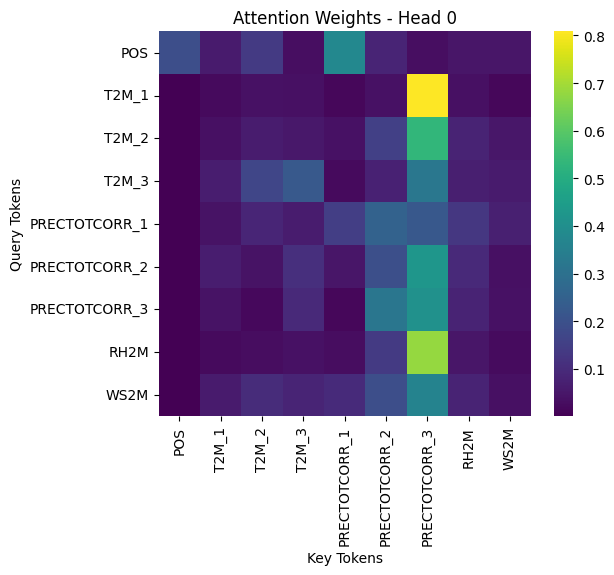

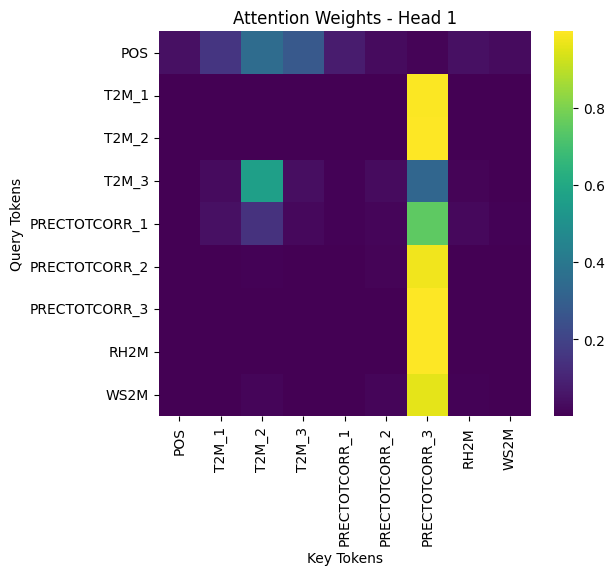

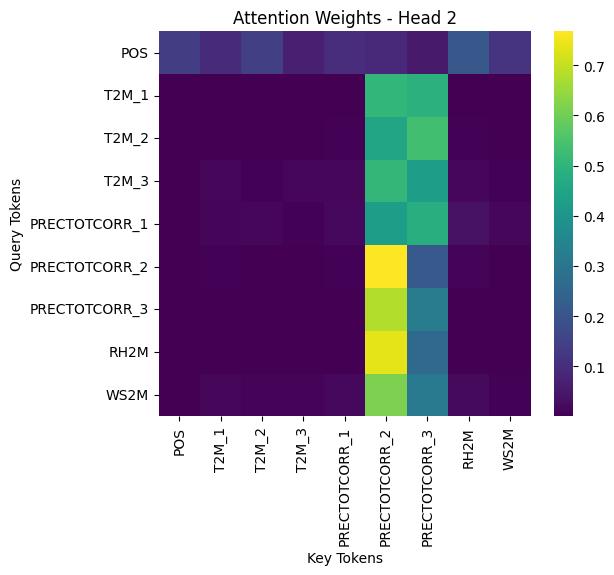

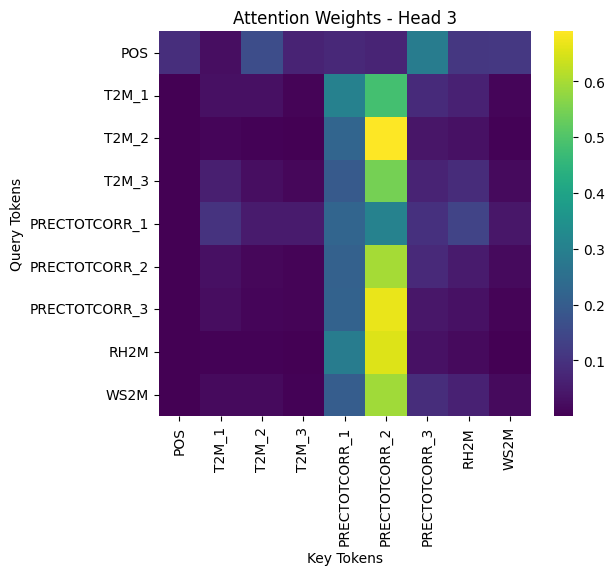

Decoder Attention Heads:


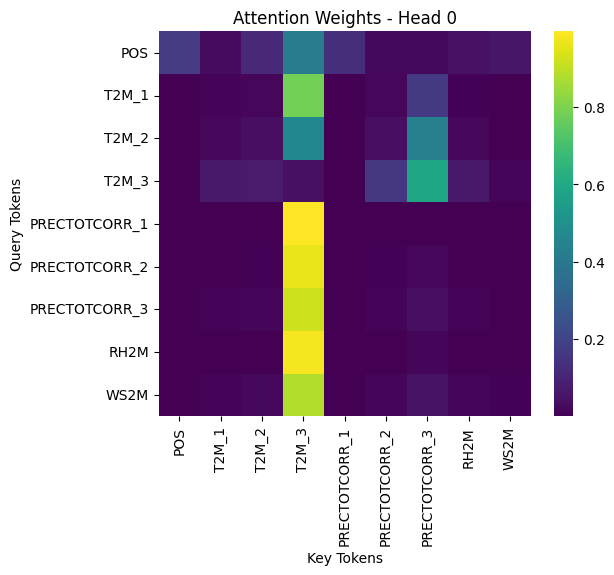

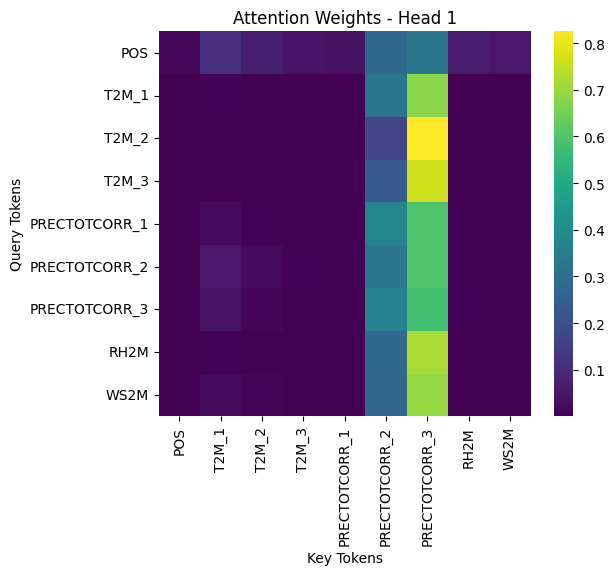

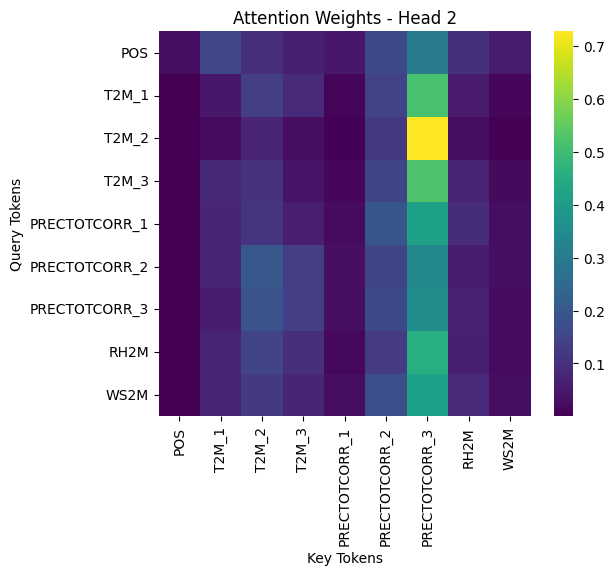

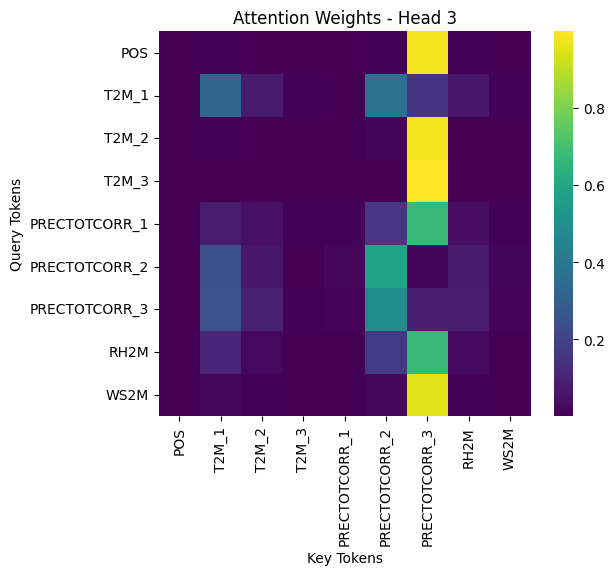

In [92]:
model.eval()
with torch.no_grad():
    xb, yb = next(iter(test_loader))  # Take one batch
    xb = xb.to(device)
    _ = model(xb)  # Forward pass

    attn = model.get_attention_weights()
    encoder_attn = attn["encoder"]  # Shape: [B, H, N, N]
    decoder_attn = attn["decoder"]  # Same shape

    labels = ["POS", 'T2M_1', 'T2M_2', 'T2M_3', 'PRECTOTCORR_1', 'PRECTOTCORR_2', 'PRECTOTCORR_3', 'RH2M', "WS2M"]

    # Plot all encoder heads
    if encoder_attn is not None:
        print("Encoder Attention Heads:")
        for head in range(encoder_attn.shape[1]):
            plot_attention(encoder_attn[0], head=head, labels=labels)

    # Plot all decoder heads
    if decoder_attn is not None:
        print("Decoder Attention Heads:")
        for head in range(decoder_attn.shape[1]):
            plot_attention(decoder_attn[0], head=head, labels=labels)


#### How many params 

In [16]:
def detailed_parameter_report(model):
    summary = defaultdict(int)
    for name, param in model.named_parameters():
        if param.requires_grad:
            top_level = name.split('.')[0]
            summary[top_level] += param.numel()

    total = sum(summary.values())

    print(f"{'Module':<20}{'Trainable Params':>20}")
    print("-" * 42)
    for module, count in summary.items():
        print(f"{module:<20}{count:>20,}")
    print("-" * 42)
    print(f"{'Total':<20}{total:>20,}")

In [17]:
detailed_parameter_report(model)

Module                  Trainable Params
------------------------------------------
pos_proj                           2,560
token_encoders                     1,024
encoder                           66,560
decoder                           66,560
output_proj                        1,154
interpolator                      22,664
------------------------------------------
Total                            160,522


#### Loss Function

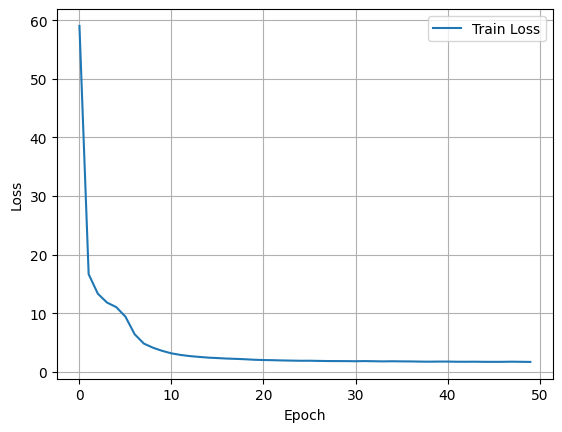

In [40]:
plt.plot(losses, label='Train Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

#### MAE AND RMSE

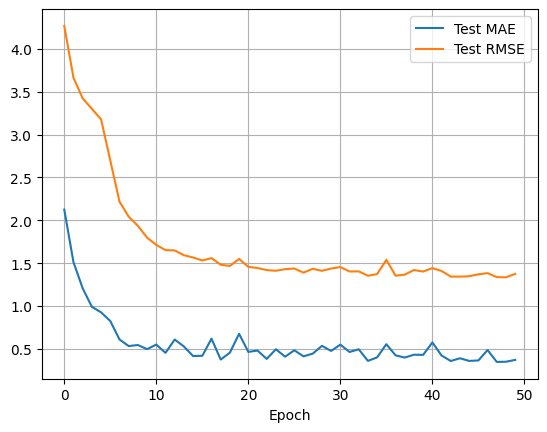

In [39]:
plt.plot(test_maes, label='Test MAE')
plt.plot(test_rmses, label='Test RMSE')

plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()


#### Real vs predicted Training

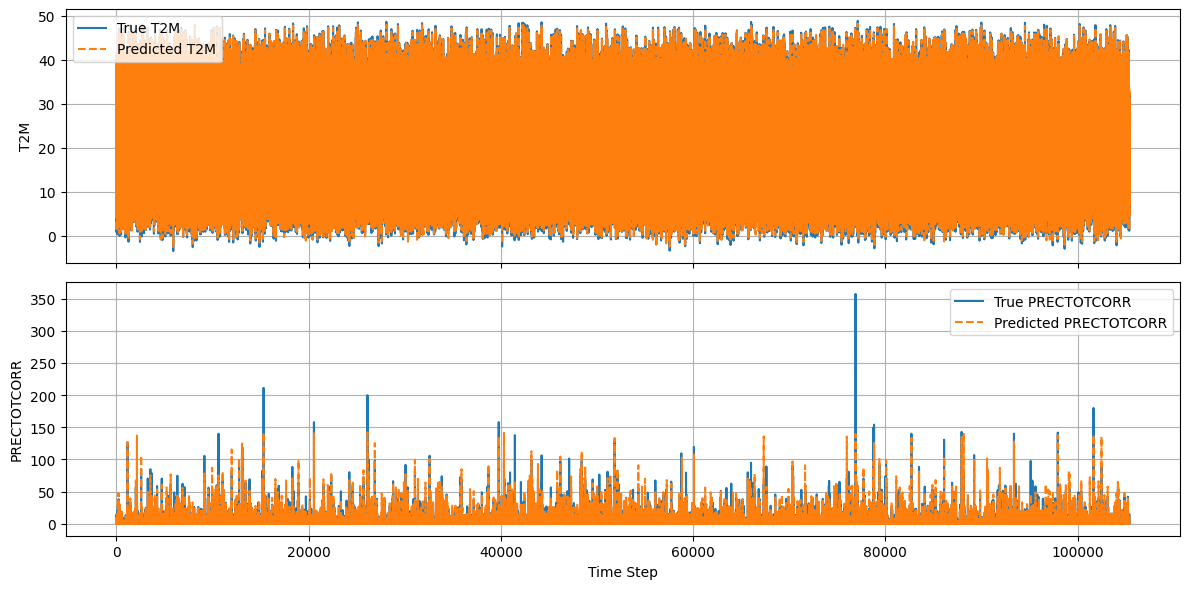

In [87]:
time_axis = np.arange(len(y_true_all_v))
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(time_axis, y_true_all_v[:, 0], label='True T2M')
axs[0].plot(time_axis, y_pred_all_v[:, 0], label='Predicted T2M', linestyle='--')
axs[0].set_ylabel('T2M')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(time_axis, y_true_all_v[:, 1], label='True PRECTOTCORR')
axs[1].plot(time_axis, y_pred_all_v[:, 1], label='Predicted PRECTOTCORR', linestyle='--')
axs[1].set_ylabel('PRECTOTCORR')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel('Time Step')

plt.tight_layout()
plt.show()


#### True vs Predicted Training ZOOMED IN

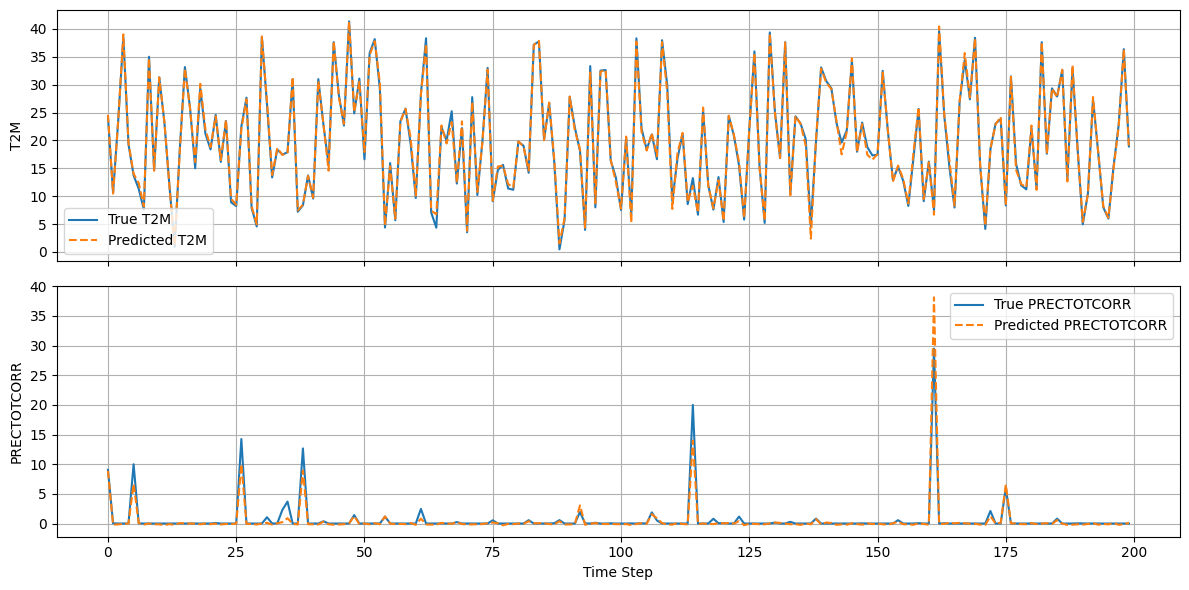

In [88]:
time_axis = np.arange(len(y_true_all_v))
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(time_axis[0:200], y_true_all_v[0:200, 0], label='True T2M')
axs[0].plot(time_axis[0:200], y_pred_all_v[0:200, 0], label='Predicted T2M', linestyle='--')
axs[0].set_ylabel('T2M')
axs[0].legend()
axs[0].grid(True)



axs[1].plot(time_axis[0:200], y_true_all_v[0:200, 1], label='True PRECTOTCORR')
axs[1].plot(time_axis[0:200], y_pred_all_v[0:200, 1], label='Predicted PRECTOTCORR', linestyle='--')
axs[1].set_ylabel('PRECTOTCORR')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel('Time Step')

plt.tight_layout()
plt.show()

#### True vs Predicted TESTING

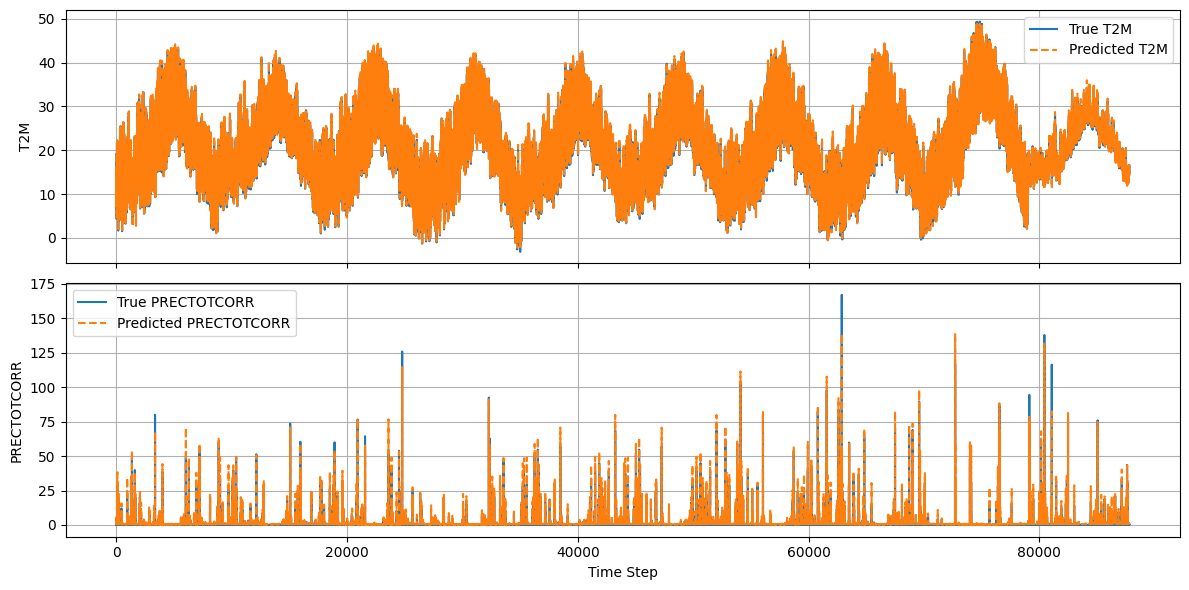

In [89]:
time_axis = np.arange(len(y_true_all_t))
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(time_axis, y_true_all_t[:, 0], label='True T2M')
axs[0].plot(time_axis, y_pred_all_t[:, 0], label='Predicted T2M', linestyle='--')
axs[0].set_ylabel('T2M')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(time_axis, y_true_all_t[:, 1], label='True PRECTOTCORR')
axs[1].plot(time_axis, y_pred_all_t[:, 1], label='Predicted PRECTOTCORR', linestyle='--')
axs[1].set_ylabel('PRECTOTCORR')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel('Time Step')

plt.tight_layout()
plt.show()


#### True vs Predicted Testing ZOOMED In

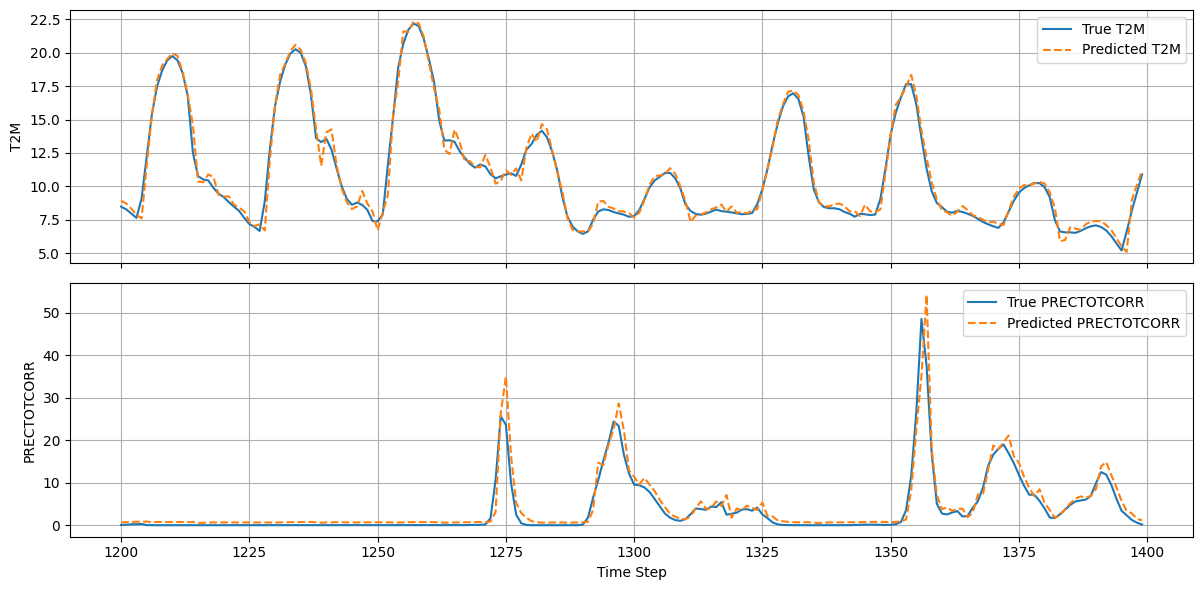

In [90]:
time_axis = np.arange(len(y_true_all_t))
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(time_axis[1200:1400], y_true_all_t[1200:1400, 0], label='True T2M')
axs[0].plot(time_axis[1200:1400], y_pred_all_t[1200:1400, 0], label='Predicted T2M', linestyle='--')
axs[0].set_ylabel('T2M')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(time_axis[1200:1400], y_true_all_t[1200:1400, 1], label='True PRECTOTCORR')
axs[1].plot(time_axis[1200:1400], y_pred_all_t[1200:1400, 1], label='Predicted PRECTOTCORR', linestyle='--')
axs[1].set_ylabel('PRECTOTCORR')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel('Time Step')

plt.tight_layout()
plt.show()

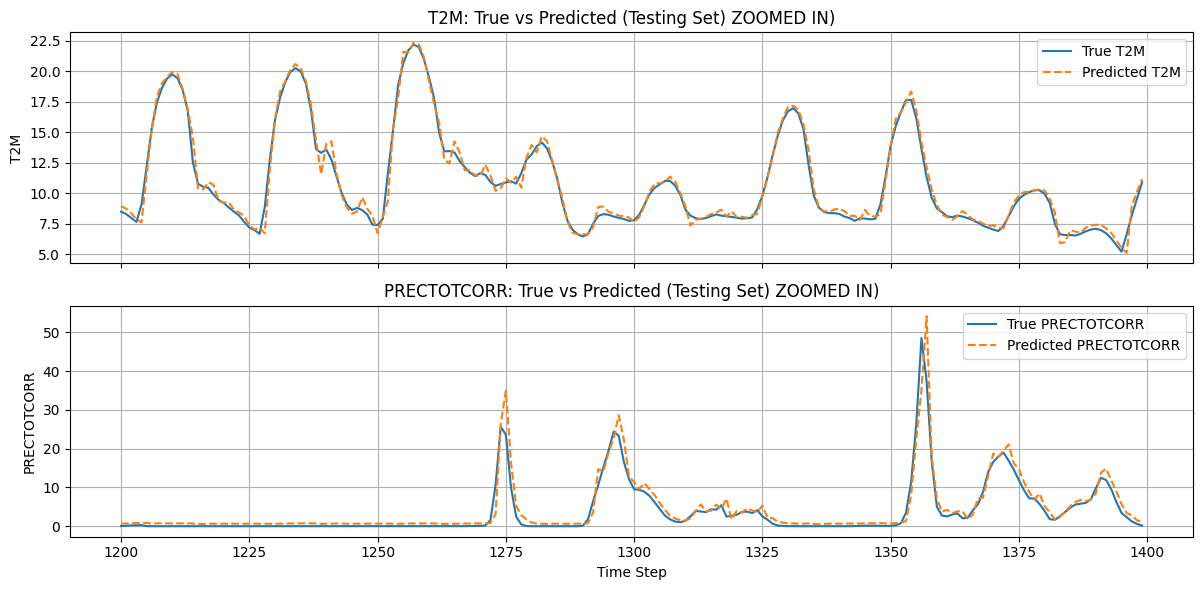

In [80]:
time_axis = np.arange(len(y_true_all_p))
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(time_axis[1200:1400], y_true_all_p[1200:1400, 0], label='True T2M')
axs[0].plot(time_axis[1200:1400], y_pred_all_p[1200:1400, 0], label='Predicted T2M', linestyle='--')
axs[0].set_ylabel('T2M')
axs[0].set_title('T2M: True vs Predicted (Testing Set) ZOOMED IN)')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(time_axis[1200:1400], y_true_all_p[1200:1400, 1], label='True PRECTOTCORR')
axs[1].plot(time_axis[1200:1400], y_pred_all_p[1200:1400, 1], label='Predicted PRECTOTCORR', linestyle='--')
axs[1].set_ylabel('PRECTOTCORR')
axs[1].set_title('PRECTOTCORR: True vs Predicted (Testing Set) ZOOMED IN)')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel('Time Step')

plt.tight_layout()
plt.show()

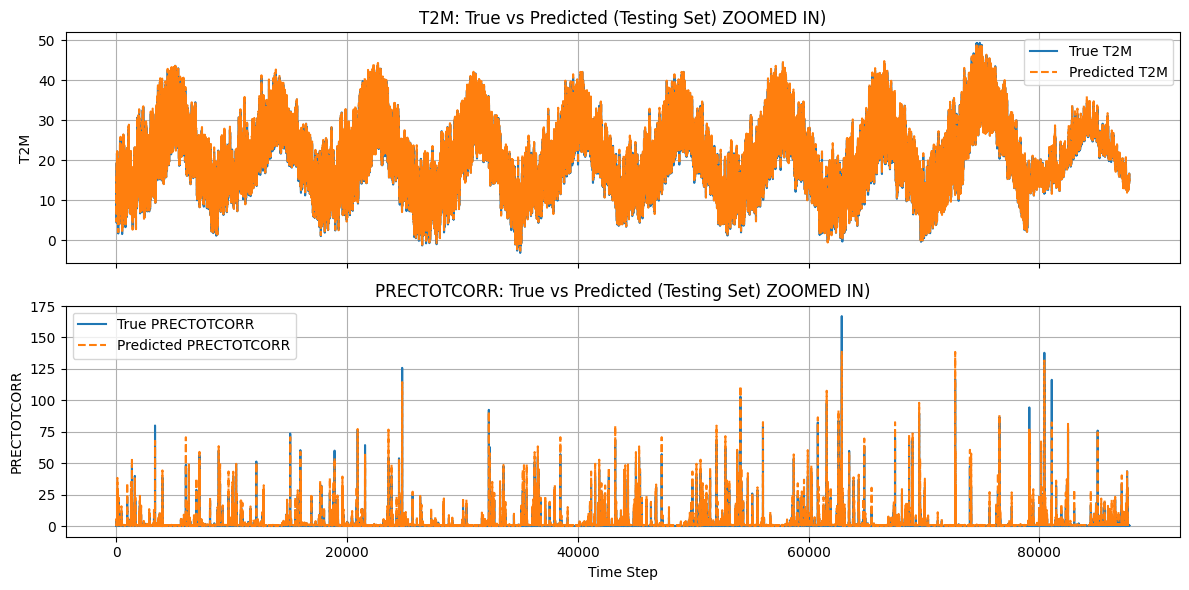

In [81]:
time_axis = np.arange(len(y_true_all_p))
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(time_axis, y_true_all_p[ :,0], label='True T2M')
axs[0].plot(time_axis, y_pred_all_p[ :,0], label='Predicted T2M', linestyle='--')
axs[0].set_ylabel('T2M')
axs[0].set_title('T2M: True vs Predicted (Testing Set) ZOOMED IN)')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(time_axis, y_true_all_p[ :,1], label='True PRECTOTCORR')
axs[1].plot(time_axis, y_pred_all_p[ :,1], label='Predicted PRECTOTCORR', linestyle='--')
axs[1].set_ylabel('PRECTOTCORR')
axs[1].set_title('PRECTOTCORR: True vs Predicted (Testing Set) ZOOMED IN)')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel('Time Step')

plt.tight_layout()
plt.show()

8760